In [10]:
# code for DP-SGD
def clip_grad(grad, C):
    return grad/np.max([1, np.linalg.norm(grad)/C])

def add_grad_noise(grad, sigma, C):
    return grad + np.random.normal(0, sigma, grad.shape)


Epoch 0: loss = 1.231333
Epoch 10: loss = 0.852933
Epoch 20: loss = 0.850519
Epoch 30: loss = 0.641828
Epoch 40: loss = 0.732598


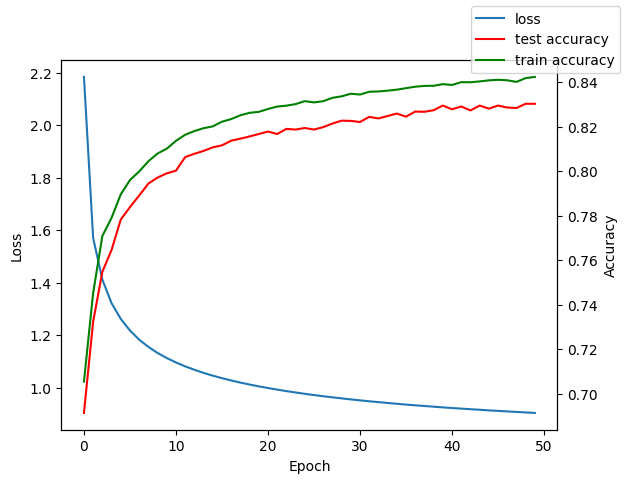

Accuracy: 0.8304


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

def plot(losses, test_accs, train_accs):
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2 = ax1.twinx()
    ax2.plot(test_accs, label="test accuracy", color="red")
    ax2.plot(train_accs, label="train accuracy", color="green")
    ax2.set_ylabel("Accuracy")
    fig.legend()
    plt.show()

def get_accuracy(x, y, w, b):
    scores = np.dot(x, w.T) + b
    probs = 1 / (1 + np.exp(-scores))
    y_pred = np.argmax(probs, axis=1)
    accuracy = np.mean(y_pred == np.argmax(y, axis=1))
    return accuracy

def compute_epsilon(batch_size, delta, sigma, iterations):
    """Compute epsilon using the moments accountant technique"""
    alpha = batch_size / x_train.shape[0]
    q = alpha * sigma
    b = q / (1 - q)
    epsilons = np.zeros(iterations)
    for i in range(iterations):
        t = i + 1
        epsilons[i] = np.sqrt(2 * np.log(1.25 / delta)) * b * sigma * t**1.5
    return np.max(epsilons)

def logistic_regression_sgd(X, y, learning_rate, num_epochs, batch_size, do_dp=False, C=1, sigma=1):
    N, D = X.shape
    K = y.shape[1]
    w = np.zeros((K, D))
    b = np.zeros(K)
    losses = np.zeros(num_epochs)
    test_accs = np.zeros(num_epochs)
    train_accs = np.zeros(num_epochs)
    epsilons = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(N)
        X = X[perm]
        y = y[perm]

        loss_avg = 0
        # Process the data in batches
        for i in range(0, N, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Forward pass
            scores = np.dot(X_batch, w.T) + b
            probs = 1 / (1 + np.exp(-scores))
            loss = -1/batch_size * \
                np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))

            # Backward pass
            dscores = 1/batch_size * (probs - y_batch)
            grad_w = np.dot(dscores.T, X_batch)
            grad_b = np.sum(dscores, axis=0)

            if do_dp:
                grad_w = clip_grad(grad_w, C)
                grad_w = add_grad_noise(grad_w, sigma, C)
                grad_b = clip_grad(grad_b, C)
                grad_b = add_grad_noise(grad_b, sigma, C)

            # Update weights
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b
            loss_avg += loss

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss:.6f}")
        test_accs[epoch] = get_accuracy(x_test, y_test, w, b)
        train_accs[epoch] = get_accuracy(x_train, y_train, w, b)
        losses[epoch] = loss_avg/(N/batch_size)
        if do_dp:
            epsilons[epoch] = compute_epsilon(batch_size, 1e-5, sigma, epoch+1)
    plot(losses, test_accs, train_accs)
    if do_dp:
        plt.plot(epsilons)
        plt.xlabel("Epoch")
        plt.ylabel("Epsilon")
        plt.show()
    return w, b


# Train the model
w, b = logistic_regression_sgd(x_train, y_train, learning_rate=0.01, num_epochs=50, batch_size=128)

# Evaluate the model on the test set
accuracy = get_accuracy(x_test, y_test, w, b)
print(f"Accuracy: {accuracy:.4f}")

Epoch 0: loss = 1.759995
Epoch 10: loss = 1.114419
Epoch 20: loss = 1.169106
Epoch 30: loss = 1.347723
Epoch 40: loss = 1.207084


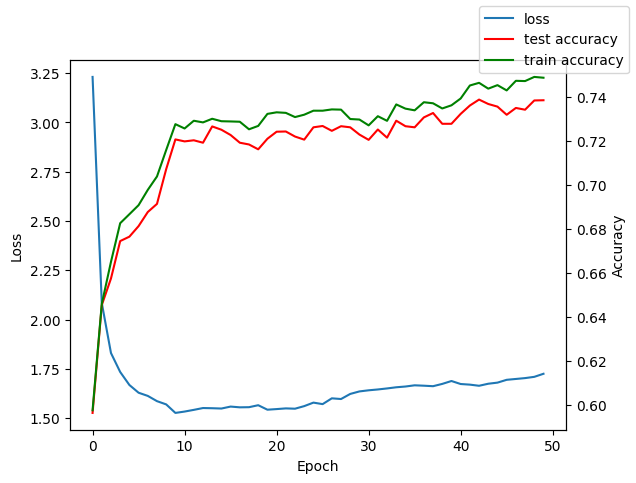

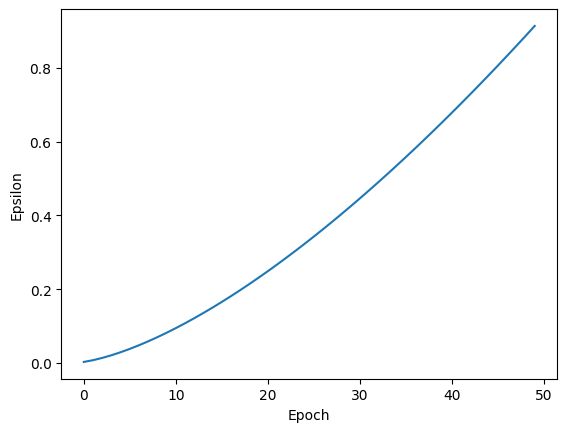

Accuracy: 0.7384


In [11]:
# Train the model with DP-SGD
w, b = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                               num_epochs=50, batch_size=128, do_dp=True, C=0.5, sigma=0.5)

# Evaluate the model on the test set
accuracy = get_accuracy(x_test, y_test, w, b)
print(f"Accuracy: {accuracy:.4f}")
